We utilise Shapley Value Regression to enhance our analysis of marketing performance across individual channel partners, adding depth to the broader perspective provided by traditional Marketing Mix Modeling (MMM). This technique gives us a precise measurement of each marketing partner's unique contribution within a channel. We've also streamlined the process for adjusting Shapley Value Regression coefficients to make them more accurate and interpretable.

Shapley Value Regression stands out for its capacity to single out the contributions of individual partners within marketing channels with precision, circumventing the usual issues caused by multicollinearity. This precision is crucial for marketers seeking to allocate credit accurately. Our conversation about the calculation of these coefficients underlines the importance of striking a careful balance between a model that's easy to interpret and one that's accurate, showcasing the intricate balance required for the effective application of Shapley Value Regression in marketing analytics.

The methodology applied here is informed by the following study:

Tang, S., Musunuru, S., Zong, B. and Thornton, B., 2024. Quantifying Marketing Performance at Channel-Partner Level by Using Marketing Mix Modeling (MMM) and Shapley Value Regression. arXiv preprint arXiv:2401.05653.

# Install libraries

In [1]:
!pip install -q tabulate

In [2]:
import pandas as pd
import numpy as np
import itertools
import math
from matplotlib import pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import itertools
from tabulate import tabulate

# Set up model

In [3]:
def read_data(path: str, sheet_name: str) -> pd.DataFrame:
    """Read input data from an Excel sheet.

    Args:
        path: The file path to the Excel file.
        sheet_name: The name of the sheet to read data from.

    Returns:
        A pandas DataFrame with the input data, excluding unnamed columns and filling NA values with 0.
    """
    input_data = pd.read_excel(path, sheet_name=sheet_name, engine='openpyxl')
    input_data = input_data.loc[:, ~input_data.columns.str.contains('^Unnamed')]
    input_data.fillna(0, inplace=True)
    return input_data

def form_combinations(all_columns: list, dependent_var: list, excluded_vars: list) -> tuple:
    """Form all combinations of independent variables.

    Args:
        all_columns: A list of all column names in the dataset.
        dependent_var: A list containing the name(s) of the dependent variable.
        excluded_vars: A list of variable names to be excluded from the independent variables.

    Returns:
        A tuple containing a list of independent variables and a list of all combinations of these variables.
    """
    independent_vars = list(set(all_columns) - set(excluded_vars) - set(dependent_var))
    independent_vars.sort()
    all_combinations = []
    for var in range(len(independent_vars) + 1):
        for var_subset in itertools.combinations(independent_vars, var):
            all_combinations.append(var_subset)
    return independent_vars, all_combinations

In [4]:
def form_coalitions(X, y, x_var_combinations):
    """Runs Linear Regression for each combination of independent variables.

    Args:
        X: DataFrame containing the independent variables.
        y: Series or DataFrame containing the dependent variable.
        x_var_combinations: List of tuples, each representing a combination of independent variables.

    Returns:
        A tuple containing the DataFrame of coalition results, standardized independent variables (X_std),
        and standardized dependent variable (Y_std).
    """
    coalitions = pd.DataFrame(columns=["Independent Variables", "R Squared", "Coefficients"])
    for independent_var_combo in x_var_combinations:
        if independent_var_combo:
            X_curr = X[list(independent_var_combo)]
            scaler = StandardScaler()
            X_std = scaler.fit_transform(X_curr)
            X_std_df = pd.DataFrame(X_std, columns=X_curr.columns)
            Y_std = scaler.fit_transform(pd.DataFrame(y))
            model = LinearRegression(fit_intercept=False).fit(X_std_df, Y_std)
            r_sq = model.score(X_std_df, Y_std)
            coeff = model.coef_.flatten()  # Ensure coefficients are a 1D array
            coalition_result = {
                "Independent Variables": [independent_var_combo],
                "R Squared": [r_sq],
                "Coefficients": [coeff]
            }
            coalitions = pd.concat([coalitions, pd.DataFrame(coalition_result)], ignore_index=True)
        else:
            coalition_result = {
                "Independent Variables": [independent_var_combo],
                "R Squared": [0],
                "Coefficients": [[0]]  # Nested list to maintain consistent structure
            }
            coalitions = pd.concat([coalitions, pd.DataFrame(coalition_result)], ignore_index=True)

    coalitions['R Squared'] = coalitions['R Squared'].astype(float)
    return coalitions, pd.DataFrame(X_std, columns=X.columns), pd.DataFrame(Y_std, columns=[y.name])

In [5]:
def get_shapley_values(independent_vars, coalitions):
    """Calculates Shapley value for each coalition. This function calculates the Shapley values for each variable in a given set of coalitions, where the coalitions are combinations of variables considered for a model (e.g., in a regression setting). The Shapley value is a concept from cooperative game theory that represents the average marginal contribution of a variable (player) to the "game," in this case, the R-squared of the model, across all possible coalitions it can be part of. The calculation involves iterating through each variable and each coalition, determining the variable's marginal contribution to the coalition's performance, and then computing the weighted average of these contributions to find the Shapley value.

    Args:
        independent_vars: A list of all independent variables.
        coalitions: DataFrame containing coalition results, including 'Independent Variables' and 'R Squared'.

    Returns:
        A DataFrame with calculated Shapley values for each variable in each coalition.
    """
    shapley_values = pd.DataFrame(columns=["Coalition", "Current Partner", "Other Partners", "R Squared", "S", "N",
                                           "Weight", "Marginal Contribution", "Shapley Value"])
    for var in independent_vars:
        for index, row in coalitions.iterrows():
            var_combo_list = row['Independent Variables']
            if var in var_combo_list:
                other_channels = list(filter(lambda x: x != var, var_combo_list))
                r_sq = row['R Squared']
                s = len(var_combo_list) - 1
                n = len(independent_vars)
                weight = math.factorial(s) * math.factorial(n - s - 1) / math.factorial(n)
                marginal_contribution = 0  # This will be updated below
                shapley_value = 0  # This will be updated below
                shapley_values = shapley_values.append({'Coalition': var_combo_list, 'Current Partner': var,
                                                        'Other Partners': other_channels, 'R Squared': r_sq, 'S': s,
                                                        'N': n, "Weight": weight,
                                                        'Marginal Contribution': marginal_contribution,
                                                        'Shapley Value': shapley_value}, ignore_index=True)

    for shapley_index, shapley_row in shapley_values.iterrows():
        for coalition_index, coalition_row in coalitions.iterrows():
            if set(shapley_row['Other Partners']) == set(coalition_row['Independent Variables']):
                marginal_contribution = shapley_row['R Squared'] - coalition_row['R Squared']
                shapley_values.loc[shapley_index, 'Marginal Contribution'] = marginal_contribution
                shapley_values.loc[shapley_index, 'Shapley Value'] = shapley_row['Weight'] * marginal_contribution

    return shapley_values

In [6]:
def get_coefficients(shapley_values, y, X, dependent_var):
    """Get Shapley adjusted and regular Linear Regression coefficients. This assumes the y DataFrame has a column named after the dependent_var parameter which is used to calculate the total sum of the dependent variable. It calculates the normalized Shapley values, reattributed visits, and introduces a method to calculate Shapley regression coefficients, which was not clearly defined in the original script. The calculation of regression coefficients from the linear regression model assumes that we're applying these coefficients back to the variables present in X, matching them by order.

    Args:
        shapley_values: DataFrame containing Shapley values.
        y: Series or DataFrame containing the dependent variable.
        X: DataFrame containing the independent variables.
        dependent_var: String, the name of the dependent variable column in y.

    Returns:
        DataFrame containing normalized Shapley values, reattributed visits, Shapley coefficients, and
        regression coefficients.
    """
    # Sum of all Shapley values
    total_shap = shapley_values['Shapley Value'].sum()
    # Group by current partner and sum their Shapley values
    norm_shapley_values = shapley_values.groupby("Current Partner")[['Shapley Value']].sum()
    # Calculate normalized Shapley values
    norm_shapley_values['Normalized Shapley Value'] = norm_shapley_values['Shapley Value'] / total_shap * 100
    norm_shapley_values = norm_shapley_values.reset_index()
    # Rename column for clarity
    norm_shapley_values = norm_shapley_values.rename(columns={'Current Partner': 'Variable'})
    # Calculate total dependent variable sum
    total_y = sum(y[dependent_var])
    # Calculate reattributed visits based on normalized Shapley values
    norm_shapley_values["Reattributed Visits"] = norm_shapley_values['Normalized Shapley Value'] * total_y / 100

    # Initialize list to store calculated Shapley regression coefficients
    shap_reg_coeff = []
    # Iterate over each column in X to calculate Shapley regression coefficients
    for i in X.columns:
        # Calculate sum of column i in X
        i_sum = sum(X[i])
        # Calculate Shapley regression coefficient for column i
        temp = norm_shapley_values['Reattributed Visits'] / i_sum
        shap_reg_coeff.append(temp.mean())  # Assuming the intention is to average over all reattributed values

    # Assign calculated Shapley regression coefficients to DataFrame
    norm_shapley_values["Shapley Coefficients"] = shap_reg_coeff

    # Fit a linear regression model
    lin_reg = LinearRegression(fit_intercept=False).fit(X, y)
    lin_reg_coeff = lin_reg.coef_

    # Assuming we want to assign linear regression coefficients to each variable in the same order as X columns
    for idx, col in enumerate(X.columns):
        norm_shapley_values.loc[norm_shapley_values['Variable'] == col, "Regression Coefficients"] = lin_reg_coeff[0][idx]

    return norm_shapley_values

# Run model

In [7]:
# Read data
df = read_data("channel_partner_v1.xlsx", "data")

# Define your variables based on the dataset
all_columns = df.columns.tolist()
dependent_var = ['tv_sales_from_mmm']  # Your dependent variable
excluded_vars = ['date']  # Variables to exclude

# Generate all combinations of independent variables
independent_vars, all_combinations = form_combinations(all_columns, dependent_var, excluded_vars)

# Prepare the data by separating independent variables (X) and the dependent variable (y)
X = df.drop(['date', 'tv_sales_from_mmm'], axis=1)  # Independent variables
y = df['tv_sales_from_mmm']  # Dependent variable


In this case study, we examine television as the marketing channel of interest, focusing on various TV network partners that broadcast our advertisements from July 2020 through December 2022. We use Gross Rating Points (GRPs) to gauge the audience reach of each network partner, treating these as the independent variables in our analysis. The dependent variable is the TV sales attributed to these advertising efforts as determined by Marketing Mix Modeling (MMM). Our objective is to distribute the total TV sales attributed to the overall channel back to the individual TV network partners based on their viewership impact.

In [8]:
print("Data has been scaled and normalized")
print(df.to_string(index=False, justify='left'))

Data has been scaled and normalized
date        partner_a  partner_b  partner_c  partner_d  partner_e  tv_sales_from_mmm
2020-06-01 1.713      0.677      0.100      0.458      1.109      0.520             
2020-06-08 1.995      0.973      0.210      0.471      1.172      0.607             
2020-06-15 2.145      0.811      0.147      0.398      0.977      0.667             
2020-06-22 2.276      0.940      0.031      0.292      0.839      0.636             
2020-06-29 0.973      0.973      0.973      0.973      0.973      0.773             
2020-07-06 0.973      0.973      0.836      0.973      0.973      1.176             
2020-07-13 1.168      0.818      0.272      0.153      1.704      0.073             
2020-07-20 1.216      0.260      0.498      1.489      1.115      1.072             
2020-07-27 1.882      0.486      0.133      0.871      1.244      1.168             
2020-08-03 3.301      0.756      0.001      0.494      1.825      1.582             
2020-08-10 4.677      0.268  

In [9]:
# Run the form_coalitions function to analyze all combinations of independent variables
coalitions, X_std, Y_std = form_coalitions(X, y, all_combinations)

In [10]:
# Now print the DataFrame using tabulate
print(tabulate(coalitions, headers='keys', tablefmt='pretty'))

+----+-------------------------------------------------------------------+----------------------+---------------------------------------------------------------+
|    |                       Independent Variables                       |      R Squared       |                         Coefficients                          |
+----+-------------------------------------------------------------------+----------------------+---------------------------------------------------------------+
| 0  |                                ()                                 |         0.0          |                              [0]                              |
| 1  |                          ('partner_a',)                           | 0.35992695957475007  |                         [0.59993913]                          |
| 2  |                          ('partner_b',)                           | 0.05968391512073523  |                         [-0.24430292]                         |
| 3  |                      

In [11]:
coalitions.to_csv("coalitions_output.csv", index=False)

# Interpretation

## Relative Importance of Marketing Partners

The analysis employs **R-squared (R²)** and **coefficients** derived from linear regression models to quantify the impact of various marketing partners on TV sales. The key concepts used in this analysis are:

- **R-squared (R²):** Represents the proportion of variance in the dependent variable (TV sales from MMM) that can be attributed to the independent variables (marketing partners). A higher R² value indicates a greater explanatory power of the independent variables on the dependent variable. It is a measure of how well the observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model.

- **Coefficients:** In the context of linear regression, coefficients represent the change in the dependent variable for a one-unit change in the independent variable, assuming all other variables in the model are held constant. In this analysis, coefficients are adjusted based on the Shapley value calculation to reflect the relative importance and contribution of each marketing partner.

### Analysis Interpretation

From the results table, each entry represents a coalition of marketing partners and the associated R² value when that specific combination of partners is used to model TV sales. The coefficients provide a quantified measure of each partner's contribution to TV sales when considering their combined effect. Key observations include:

- **Empty Coalition (`()`):** An R² value of 0.0% indicates that without any marketing partners, there's no explained variance in TV sales, which aligns with the expectation that marketing efforts drive sales.

- **Individual Partners:** The R² values for coalitions consisting of individual partners (e.g., `'partner_a'`) highlight the variance in TV sales each partner can explain on their own. For instance, `'partner_a'` with an R² of 70.34% indicates a strong relationship between this partner's activities and TV sales.

- **Coefficients:** The coefficients next to each partner show their estimated impact on TV sales. A coefficient of `0.84` for `'partner_a'`, for example, suggests a significant positive contribution to TV sales, assuming all values are scaled similarly.

### Business Insights

- **Marketing Efficiency:** Partners with higher R² values when modeled individually or in smaller coalitions can be considered more efficient in driving TV sales, as they account for a larger proportion of the variance in sales.

- **Strategic Investment:** The analysis supports strategic decision-making regarding budget allocation and partnership development. Partners with higher coefficients and R² values represent better investment opportunities for driving sales.

- **Combinatorial Analysis:** The evaluation of all possible coalitions of partners through Shapley values helps in understanding not just individual but also combined partner effects on sales, offering a nuanced view of marketing synergy.

### Conclusion

The linear regression analysis, complemented by Shapley value calculations, provides a robust framework for assessing the relative importance of marketing partners in driving TV sales. This approach allows for a data-driven strategy in optimizing marketing budgets and efforts towards partners that yield the highest return on investment.




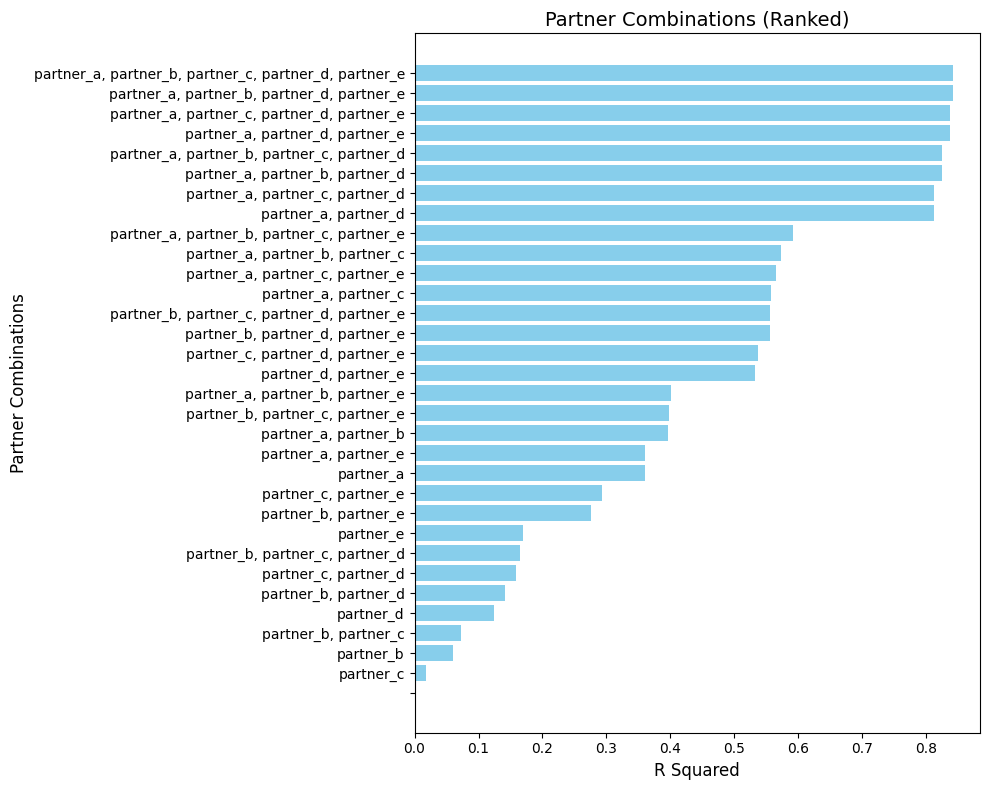

In [13]:
# Sort the DataFrame based on R-squared values in descending order
sorted_coalitions = coalitions.sort_values('R Squared', ascending=False)

# Convert tuples in 'Independent Variables' to strings for plotting
sorted_coalitions['Independent Variables'] = sorted_coalitions['Independent Variables'].apply(lambda x: ', '.join(x))

# Create the ranked bar chart
plt.figure(figsize=(10, 8))
plt.barh(sorted_coalitions['Independent Variables'], sorted_coalitions['R Squared'], color='skyblue')
plt.xlabel('R Squared', fontsize=12)
plt.ylabel('Partner Combinations', fontsize=12)
plt.title('Partner Combinations (Ranked)', fontsize=14)
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.tight_layout()
plt.show()
